In [103]:
# === Imports de base ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# === Machine learning ===
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# === Configuration des affichages ===
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [134]:
# Chargement des jeux de données
df_interaction = pl.read_csv("../data/raw/RAW_interactions.csv")
df_recipe = pl.read_csv("../data/raw/RAW_recipes.csv")

print("✅ Données chargées avec succès.")
print(df_interaction.shape)
df_interaction.head()

df_total = pl.read_parquet('../data/processed/total.parquet')
df_total.head()

✅ Données chargées avec succès.
(1132367, 5)


shape: (5, 16)
┌─────────┬───────────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ user_id ┆ recipe_id ┆ date       ┆ rating ┆ … ┆ steps      ┆ descriptio ┆ ingredient ┆ n_ingredi │
│ ---     ┆ ---       ┆ ---        ┆ ---    ┆   ┆ ---        ┆ n          ┆ s          ┆ ents      │
│ i64     ┆ i64       ┆ datetime[μ ┆ i64    ┆   ┆ str        ┆ ---        ┆ ---        ┆ ---       │
│         ┆           ┆ s]         ┆        ┆   ┆            ┆ str        ┆ str        ┆ i64       │
╞═════════╪═══════════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 38094   ┆ 40893     ┆ 2003-02-17 ┆ 4      ┆ … ┆ ['combine  ┆ easy soup  ┆ ['great    ┆ 9         │
│         ┆           ┆ 00:00:00   ┆        ┆   ┆ beans ,    ┆ for the    ┆ northern   ┆           │
│         ┆           ┆            ┆        ┆   ┆ onion ,    ┆ crockpot.  ┆ beans',    ┆           │
│         ┆           ┆            ┆        ┆   ┆ chil…      ┆            ┆ 'yell…     ┆           │
│ 1293707 ┆ 40893     ┆ 2011-12-21 ┆ 5      ┆ … ┆ ['combine  ┆ easy soup  ┆ ['great    ┆ 9         │
│         ┆           ┆ 00:00:00   ┆        ┆   ┆ beans ,    ┆ for the    ┆ northern   ┆           │
│         ┆           ┆            ┆        ┆   ┆ onion ,    ┆ crockpot.  ┆ beans',    ┆           │
│         ┆           ┆            ┆        ┆   ┆ chil…      ┆            ┆ 'yell…     ┆           │
│ 8937    ┆ 44394     ┆ 2002-12-01 ┆ 4      ┆ … ┆ ['blend    ┆ null       ┆ ["devil's  ┆ 4         │
│         ┆           ┆ 00:00:00   ┆        ┆   ┆ together   ┆            ┆ food cake  ┆           │
│         ┆           ┆            ┆        ┆   ┆ cake mix , ┆            ┆ mix",      ┆           │
│         ┆           ┆            ┆        ┆   ┆ oi…        ┆            ┆ 'veg…      ┆           │
│ 126440  ┆ 85009     ┆ 2010-02-27 ┆ 5      ┆ … ┆ ['pick     ┆ these      ┆ ['mayonnai ┆ 13        │
│         ┆           ┆ 00:00:00   ┆        ┆   ┆ whichever  ┆ toppings   ┆ se',       ┆           │
│         ┆           ┆            ┆        ┆   ┆ topping    ┆ sure makes ┆ 'salsa',   ┆           │
│         ┆           ┆            ┆        ┆   ┆ you w…     ┆ a ni…      ┆ 'chedd…    ┆           │
│ 57222   ┆ 85009     ┆ 2011-10-01 ┆ 5      ┆ … ┆ ['pick     ┆ these      ┆ ['mayonnai ┆ 13        │
│         ┆           ┆ 00:00:00   ┆        ┆   ┆ whichever  ┆ toppings   ┆ se',       ┆           │
│         ┆           ┆            ┆        ┆   ┆ topping    ┆ sure makes ┆ 'salsa',   ┆           │
│         ┆           ┆            ┆        ┆   ┆ you w…     ┆ a ni…      ┆ 'chedd…    ┆           │
└─────────┴───────────┴────────────┴────────┴───┴────────────┴────────────┴────────────┴───────────┘

In [105]:
import polars as pl

df_user = (
    df_total
    .with_columns(
        tags_clean = (
            pl.col("tags")
            .str.replace_all(r"[\[\]']", "")            # remove brackets & quotes
            .str.replace_all(r"^\s+|\s+$", "")          # remove leading/trailing spaces
            .str.split(",")                          # split on comma + optional spaces
        )
    )
    .group_by("user_id")
    .agg(
        nb_reviews     = pl.len(),
        mean_rating    = pl.col("rating").mean(),
        std_rating     = pl.col("rating").std(),
        mean_steps     = pl.col("n_steps").mean(),
        all_tags       = pl.col("tags_clean").flatten().unique().sort(),
        mean_time      = pl.col("minutes").mean(),
        nb_ingredients = pl.col("n_ingredients").mean(),
    )
)

df_user = df_user.with_columns(
    pl.col("std_rating").fill_nan(0).alias("std_rating")
)



In [106]:
df_user.head()

shape: (5, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ user_id    ┆ nb_reviews ┆ mean_ratin ┆ std_ratin ┆ mean_step ┆ all_tags  ┆ mean_time ┆ nb_ingred │
│ ---        ┆ ---        ┆ g          ┆ g         ┆ s         ┆ ---       ┆ ---       ┆ ients     │
│ i64        ┆ u32        ┆ ---        ┆ ---       ┆ ---       ┆ list[str] ┆ f64       ┆ ---       │
│            ┆            ┆ f64        ┆ f64       ┆ f64       ┆           ┆           ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2001882261 ┆ 1          ┆ 5.0        ┆ null      ┆ 6.0       ┆ [" 5-ingr ┆ 20.0      ┆ 4.0       │
│            ┆            ┆            ┆           ┆           ┆ edients-o ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ r-less",  ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ " c…      ┆           ┆           │
│ 887315     ┆ 1          ┆ 0.0        ┆ null      ┆ 13.0      ┆ [" americ ┆ 30.0      ┆ 12.0      │
│            ┆            ┆            ┆           ┆           ┆ an", "    ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ appetizer ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ s", ……    ┆           ┆           │
│ 1625331    ┆ 1          ┆ 2.0        ┆ null      ┆ 16.0      ┆ ["        ┆ 60.0      ┆ 11.0      │
│            ┆            ┆            ┆           ┆           ┆ cheese",  ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ " comfort ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ -food",   ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ ……        ┆           ┆           │
│ 2702373    ┆ 3          ┆ 5.0        ┆ 0.0       ┆ 7.333333  ┆ [" 3-step ┆ 33.333333 ┆ 6.333333  │
│            ┆            ┆            ┆           ┆           ┆ s-or-less ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ ", "      ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ 5-ingre…  ┆           ┆           │
│ 98355      ┆ 2          ┆ 3.0        ┆ 1.414214  ┆ 11.5      ┆ [" 4-hour ┆ 121.0     ┆ 9.0       │
│            ┆            ┆            ┆           ┆           ┆ s-or-less ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ ", "      ┆           ┆           │
│            ┆            ┆            ┆           ┆           ┆ beginne…  ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

In [107]:
df_user["nb_reviews"].to_numpy()

array([1, 1, 1, ..., 1, 2, 1], shape=(225707,), dtype=uint32)

In [108]:
import plotly.express as px

# Histogram (log x-axis)
fig = px.histogram(
    x=df_user["nb_reviews"].to_numpy(),
    nbins=50,
    log_x=True,
    title="Distribution du nombre de reviews par utilisateur"
)
fig.update_layout(xaxis_title="nb_reviews", yaxis_title="count")
fig.show()

# Scatter plot
fig = px.scatter(
    x=df_user["nb_reviews"].to_numpy(),
    y=df_user["mean_rating"].to_numpy(),
    opacity=0.5,
    title="Relation entre activité et note moyenne",
    labels={"x": "nb_reviews", "y": "mean_rating"}
)
fig.show()


In [109]:
df_user.columns

['user_id',
 'nb_reviews',
 'mean_rating',
 'std_rating',
 'mean_steps',
 'all_tags',
 'mean_time',
 'nb_ingredients']

In [126]:
features = [
 'nb_reviews',
 'mean_rating',
 'std_rating',
 'mean_steps',
 'nb_ingredients']
df_user = df_user.drop_nulls()
X = df_user[features].to_pandas()

# Transformation logarithmique sur nb_reviews (évite les valeurs extrêmes)
X["nb_reviews"] = np.log1p(X["nb_reviews"])

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


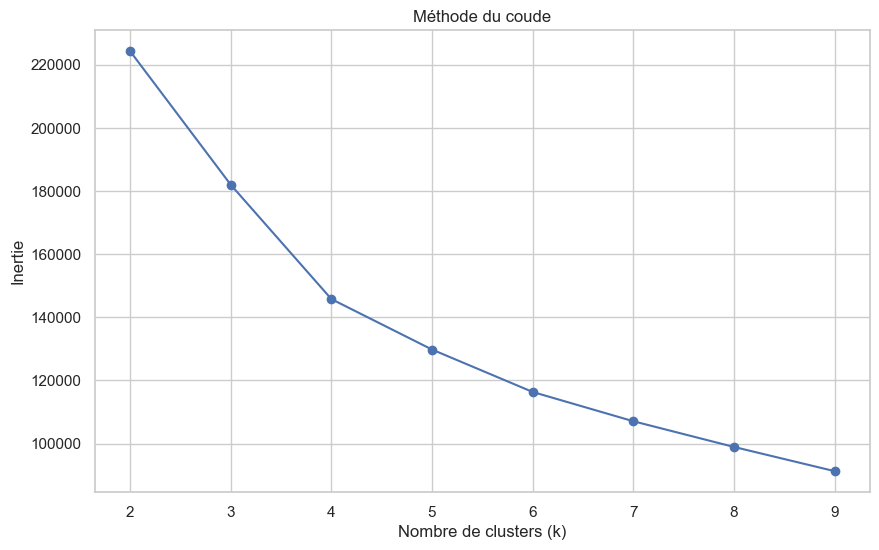

In [127]:
inertias = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title("Méthode du coude")
plt.show()


The elbow method helps us to find the optimal number of clusters.

In [131]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_user = df_user.with_columns(cluster = kmeans.fit_predict(X_scaled))

print("✅ Clustering terminé.")
df_user["cluster"].value_counts()


✅ Clustering terminé.


shape: (4, 2)
┌─────────┬───────┐
│ cluster ┆ count │
│ ---     ┆ ---   │
│ i32     ┆ u32   │
╞═════════╪═══════╡
│ 2       ┆ 11599 │
│ 0       ┆ 11509 │
│ 3       ┆ 23682 │
│ 1       ┆ 13284 │
└─────────┴───────┘

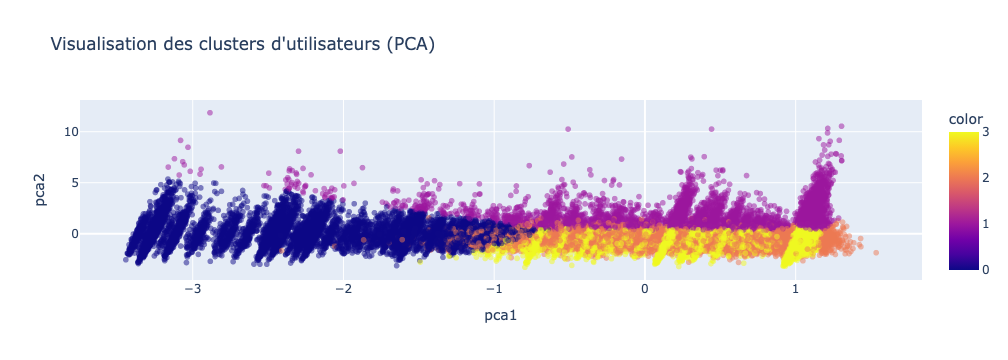

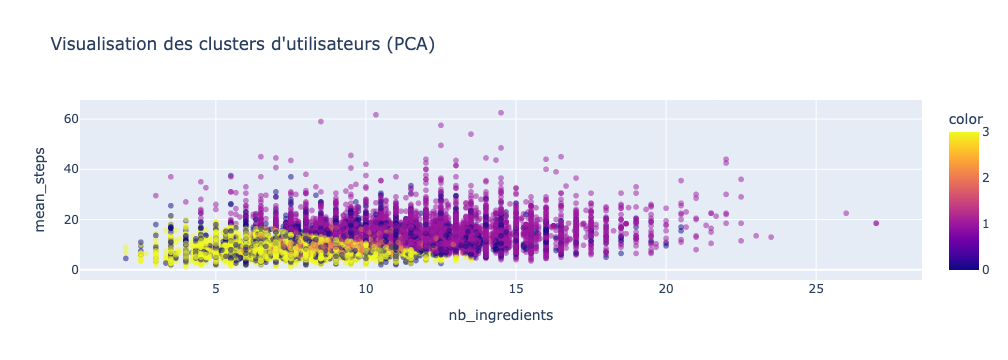

In [132]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_user = df_user.with_columns(pca1 = X_pca[:, 0])
df_user = df_user.with_columns(pca2 = X_pca[:, 1])


# Scatter plot
fig = px.scatter(
    x=df_user["pca1"].to_numpy(),
    y=df_user["pca2"].to_numpy(),
    color=df_user["cluster"].to_numpy(),
    opacity=0.5,
    title="Visualisation des clusters d'utilisateurs (PCA)",
    labels={"x": "pca1", "y": "pca2"}
)
fig.show()

fig = px.scatter(
    x=df_user["nb_ingredients"].to_numpy(),
    y=df_user["mean_steps"].to_numpy(),
    color=df_user["cluster"].to_numpy(),
    opacity=0.5,
    title="Visualisation des clusters d'utilisateurs (PCA)",
    labels={"x": "nb_ingredients", "y": "mean_steps"}
)
fig.show()

In [135]:

df_interaction = pl.read_csv("../data/raw/RAW_interactions.csv")

df_interaction = df_interaction.join(
    df_user.select(["user_id", "cluster"]),
    on="user_id",
    how="left"     # keep all interactions; add cluster where user_id matches
)

In [136]:
df_interaction.head()

shape: (5, 6)
┌─────────┬───────────┬────────────┬────────┬─────────────────────────────────┬─────────┐
│ user_id ┆ recipe_id ┆ date       ┆ rating ┆ review                          ┆ cluster │
│ ---     ┆ ---       ┆ ---        ┆ ---    ┆ ---                             ┆ ---     │
│ i64     ┆ i64       ┆ str        ┆ i64    ┆ str                             ┆ i32     │
╞═════════╪═══════════╪════════════╪════════╪═════════════════════════════════╪═════════╡
│ 38094   ┆ 40893     ┆ 2003-02-17 ┆ 4      ┆ Great with a salad. Cooked on … ┆ 2       │
│ 1293707 ┆ 40893     ┆ 2011-12-21 ┆ 5      ┆ So simple, so delicious! Great… ┆ 2       │
│ 8937    ┆ 44394     ┆ 2002-12-01 ┆ 4      ┆ This worked very well and is E… ┆ 2       │
│ 126440  ┆ 85009     ┆ 2010-02-27 ┆ 5      ┆ I made the Mexican topping and… ┆ 2       │
│ 57222   ┆ 85009     ┆ 2011-10-01 ┆ 5      ┆ Made the cheddar bacon topping… ┆ 2       │
└─────────┴───────────┴────────────┴────────┴─────────────────────────────────┴─────────┘

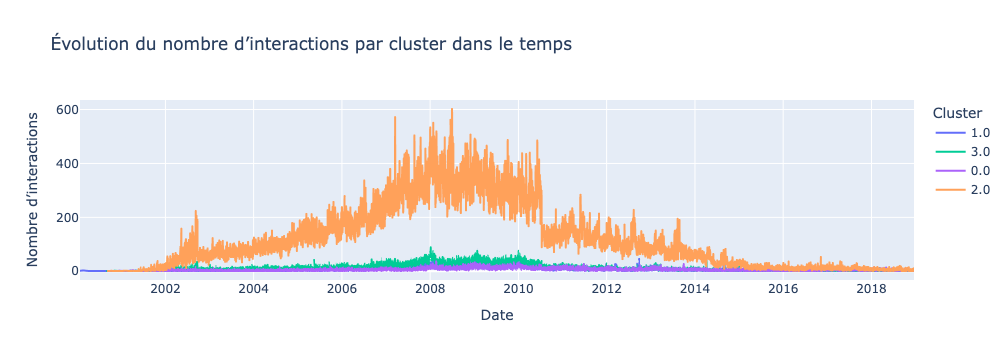

In [137]:
df_time = (
    df_interaction
    .group_by(["date", "cluster"])
    .agg(pl.len().alias("n_interactions"))
    .sort("date")
)

# 3️⃣  Plot with Plotly
fig = px.line(
    df_time.to_pandas(),
    x="date",
    y="n_interactions",
    color="cluster",
    title="Évolution du nombre d’interactions par cluster dans le temps",
    labels={"date": "Date", "n_interactions": "Nombre d’interactions", "cluster": "Cluster"}
)
fig.show()

In [125]:
cluster_summary = df_user.groupby("cluster")[features].mean().round(2)
cluster_summary["effectif"] = df_user["cluster"].value_counts()
cluster_summary


AttributeError: 'DataFrame' object has no attribute 'groupby'